# Detecting Urgent Aid Requests in Haitian Disaster Messages

![Haiti Earthquake Response](./images/pict.webp)  
*Photo: Humanitarian aid distribution (Source: [HuffPost](https://www.huffpost.com/entry/remembering-the-2010-earthquake-that-devastated-haiti_n_65036d3ee4b084b3a93f65d3))*

## Table of Contents

1. [Project summary](#1-project-summary)  
2. [Business understanding](#2-business-understanding)  
3. [Data collection and description](#3-data-collection-and-description)  
4. [Data understanding and preparation](#4-data-understanding-and-preparation)  
5. [Exploratory text analysis](#5-exploratory-text-analysis)  
6. [Modeling](#6-modeling)  
7. [Evaluation](#7-evaluation)  
8. [Model interpretability & insights](#8-model-interpretability--insights)  
9. [Recommendations](#9-recommendations)
10. [Next steps, limitations, and conclusion](#10-next-steps-limitations-and-conclusion)
11. [Reproducibility](#11-reproducibility)

## 1. Project summary

This project develops an interpretable NLP system to classify Haitian disaster response messages into two operational categories: **urgent requests for aid** and **informational content**. This project uses a subset of the Figure Eight Disaster Response dataset, focusing on messages related to the 2010 Haiti earthquake. The final model is a tuned Logistic Regression classifier that uses TF-IDF trigram features, lemmatized text, and class balancing to handle the near-equal distribution of request (51.5%) and info (48.5%) messages.

The system achieves **77% accuracy**, **0.77 macro F1-score**, and **0.86 ROC-AUC**, demonstrating strong and balanced performance. Crucially, it is fully interpretable: predictions rely on linguistically meaningful terms such as "need water," "baby food," and "tent please", phrases that directly reflect real humanitarian needs. This transparency allows field responders to understand, trust, and act on model outputs with confidence.

The project confirms that even simple, well-tuned models can deliver significant operational value in crisis settings, provided they prioritize clarity over complexity. The focus on human-centered design, linguistic relevance, and ethical responsibility offers a reliable, scalable, and deployable tool for emergency communication teams. It supports faster triage of genuine pleas for help while keeping human judgment at the center of life-critical decisions.

## 2. Business understanding

In the immediate aftermath of the 2010 Haiti earthquake, humanitarian organizations received an overwhelming volume of crisis messages through SMS, social media, and community reports. These messages mixed urgent pleas for food, water, shelter, and medical aid with general updates, logistical inquiries, and non-actionable content. Manual triage was slow, inconsistent, and unsustainable under pressure. Without rapid prioritization, genuine requests for life-saving assistance risked being overlooked, delaying critical interventions and worsening outcomes for affected communities.

### 2.1 Project goal
This project develops an automated, interpretable NLP system that classifies Haitian disaster messages into two operational categories:  
- `request`: Messages that express an urgent need for humanitarian aid  
- `info`: All other messages (updates, questions, offers, or neutral statements)  

The system aims to accelerate triage, reduce responder workload, and ensure that the most urgent pleas receive priority attention, all while maintaining transparency and trust.

### 2.2 Stakeholders
#### a. Primary stakeholders  
- Humanitarian response teams (UN OCHA, Red Cross, local NGOs):  
  Frontline actors who rely on timely, accurate message filtering to deploy aid, assign field staff, and coordinate logistics. They require high recall for urgent requests and clear justification for model decisions.  
- Affected communities in Haiti:  
  Individuals and families who send messages seeking assistance. Their safety and survival depend on whether their pleas are correctly identified and escalated.

#### b. Secondary stakeholders
- Technology partners: Integrate the classifier into crisis communication platforms (Ushahidi, WhatsApp bots).  
- Donors and policy makers: Fund response efforts and set standards for responsible AI use in emergencies. They prioritize accountability, reproducibility, and measurable impact.

### 2.3 Success Criteria
The project is successful if the model meets the following criteria:  
- Macro F1-score ≥ 0.75: Balanced performance across `request` and `info` classes.  
- Recall for `request` ≥ 0.75: Capture at least three out of four urgent messages.  
- ROC-AUC ≥ 0.85: Strong ability to rank urgent messages above non-urgent ones.  
- Interpretability: Top predictive features must align with real-world humanitarian keywords (water, tent, baby, help).  
- Operational feasibility: Lightweight, fast, and deployable in low-resource environments.

## 3. Data collection and description

In [1]:
# core libraries
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# nlp tools
import nltk
import ssl
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

import streamlit as st
import joblib
from deep_translator import GoogleTranslator

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# download NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

True

The analysis uses two structured CSV files from the `Disaster Response Messages` dataset, originally published by Figure Eight (now Appen). This dataset supports humanitarian AI development through real-world crisis communications.

`disaster_messages.csv` contains raw message records with four key fields:
- id: A unique identifier for each message
- message: An English-translated version of the original text, used as the primary input for modeling
- original: The message in its native language, typically Haitian Creole or French
- genre: The source channel, categorized as direct (firsthand pleas), news (third-party reports), or social (public posts, often from Twitter)

`disaster_categories.csv` provides multi-label annotations for each message in a single semicolon-delimited string ("request-1;offer-0;food-1;water-1;..."). Each segment encodes a humanitarian category and its binary label (1 = present, 0 = absent).

In [2]:
# load messages dataset
messages = pd.read_csv("disaster_messages.csv")
print("Messages columns:", messages.columns.tolist())

Messages columns: ['id', 'message', 'original', 'genre']


In [3]:
# load categories dataset
cat = pd.read_csv("disaster_categories.csv")
print("Categories columns:", cat.columns.tolist())

Categories columns: ['id', 'categories']


The two files share a common id column, which enables reliable record linkage.

### 3.1 Data source context and composition
The dataset originates from crowdsourced annotation efforts during three major disasters: the 2010 Haiti earthquake, Hurricane Sandy (2012), and the Nepal earthquake (2015). Messages were gathered from SMS, social media, and news outlets, then translated into English and labeled across 36 humanitarian categories by multiple human annotators to ensure consistency.

For this project, the scope is limited to Haiti-related direct messages only, as the operational goal is to support response efforts specific to the 2010 earthquake. This focus ensures contextual relevance and avoids dilution from unrelated global events.

In [4]:
print("Messages shape:", messages.shape)
print("Categories shape:", cat.shape)

Messages shape: (26248, 4)
Categories shape: (26248, 2)


The raw data consists of 26 382 message records, with matching entries in both files. All messages include complete id, message, and genre fields, and every record has a corresponding category annotation.

### 3.2 Merging datasets

In [5]:
# merge the datasets
df = messages.merge(cat, left_on='id', right_on='id', how='inner')
df.head()

,id,message,original,genre,categories
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,related-1;request-0;offer-0;aid_related-0;medi...
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,related-1;request-0;offer-0;aid_related-1;medi...
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,related-1;request-0;offer-0;aid_related-0;medi...
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,related-1;request-1;offer-0;aid_related-1;medi...
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,related-1;request-0;offer-0;aid_related-0;medi...


In [6]:
df.shape

(26386, 5)

In [7]:
# save merged file
df.to_csv('merged_disaster_data.csv', index=False)

The two files are joined on the id column using an inner join to create a unified dataset. This merge produces a single table with 26 382 rows and 5 initial columns (id, message, original, genre, categories). The resulting structure serves as the foundation for all downstream processing, filtering, and modeling.

## 4. Data understanding and preparation

### 4.1 Initial Inspection
We inspect the first few rows and assess data quality:

In [8]:
# missing values
print("\nMissing values in dataset:\n", df.isnull().sum())

# duplicates
print(f"\nDuplicate message IDs: {df.duplicated(subset='id').sum()}")


Missing values in dataset:
 id                0
message           0
original      16140
genre             0
categories        0
dtype: int64

Duplicate message IDs: 206


Initial inspection confirms no missing values in core fields (id, message, genre, categories). A small number of duplicate id entries exist, which are addressed during deduplication after filtering.

### 4.2 Category preprocessing

The categories column stores 36 humanitarian labels in a semicolon-delimited format ("request-1;food-1;shelter-0;..."). This string is split into individual columns, and label names (request, food) are extracted from the first row. Each value is converted to a binary numeric format (0 or 1) by taking the final character of each segment and casting it to an integer. The original categories column is then replaced with these 36 structured binary features.

In [9]:
# create a dataframe of the 36 individual category columns
categories = df["categories"].str.split(';', expand=True)

# extract category names from the first row
category_col = categories.iloc[0].str.split('-').str[0].tolist()

# rename the columns of `categories`
categories.columns = category_col

# convert category values to just numbers 0 or 1
for column in categories:
    # set each value to be the last character of the string
    categories[column] = categories[column].str[-1]
    
    # convert column from string to numeric
    categories[column] = pd.to_numeric(categories[column])

# drop the original categories column from `df`
df.drop(['categories'], axis=1, inplace = True)

# concatenate the original dataframe with the new `categories` dataframe
df = pd.concat([df, categories], axis=1)
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 4.3 Filter for Haiti related data

To ensure contextual relevance to the 2010 Haiti earthquake, the dataset is filtered. After this filter, only messages labeled as disaster-related (related = 1) are retained. Duplicate entries are removed to prevent data leakage. The final dataset contains 15 420 Haiti-specific, disaster-related messages.

A binary target variable is defined:

- request: messages with request = 1
- info: all other messages

In [10]:
haiti_mask = (
    (df['genre'] == 'direct') |
    (df['original'].str.contains('Haiti', case=False, na=False)) |
    (df['message'].str.contains('Haiti', case=False, na=False))
)
df = df[haiti_mask].copy()

# keep only disaster-related messages
df = df[df["related"] == 1].reset_index(drop=True)

# remove duplicates (based on message + genre)
df = df.drop_duplicates(subset=['message', 'genre']).reset_index(drop=True)

In [11]:
conditions = [
    (df["request"] == 1),
    (df["request"] == 0)
]
choices = ["request", "info"]
df["target"] = np.select(conditions, choices, default="info")

target_counts = df["target"].value_counts()
target_percentages = df["target"].value_counts(normalize=True) * 100

# combine counts and percentages
target_summary = pd.DataFrame({
    'Count': target_counts,
    'Percentage (%)': target_percentages.round(1)
})

print(target_summary)

         Count  Percentage (%)
target                        
info      3973            51.5
request   3735            48.5


The resulting class distribution is 51.5% request and 48.5% info, reflecting the urgent, need-driven nature of crisis communications.

### 4.4 Text preprocessing

Each English-translated message undergoes standardized cleaning:

- Conversion to lowercase
- Removal of URLs, social media mentions, hashtags, and punctuation
- Tokenization into words
- Filtering of English stopwords and non-alphabetic tokens
- Lemmatization to reduce words to their root forms ("needs" → "need")

The output is a cleaned, normalized text field (clean_message) suitable for vectorization and modeling.

In [19]:
import nltk, ssl, os

# ensure ssl download works
try:
    _create_unverified_https_context = ssl._create_unverified_context
    ssl._create_default_https_context = _create_unverified_https_context
except Exception:
    pass

# set nltk data path manually
nltk_data_dir = os.path.join(os.getcwd(), "nltk_data")
if not os.path.exists(nltk_data_dir):
    os.mkdir(nltk_data_dir)
nltk.data.path.append(nltk_data_dir)

# download all required tokenizers and lexicons
nltk.download('punkt', download_dir=nltk_data_dir)
nltk.download('punkt_tab', download_dir=nltk_data_dir)
nltk.download('stopwords', download_dir=nltk_data_dir)
nltk.download('wordnet', download_dir=nltk_data_dir)
nltk.download('omw-1.4', download_dir=nltk_data_dir)



[nltk_data] Downloading package punkt to
[nltk_data]     c:\Users\WJ619024\Downloads\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     c:\Users\WJ619024\Downloads\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     c:\Users\WJ619024\Downloads\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     c:\Users\WJ619024\Downloads\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     c:\Users\WJ619024\Downloads\nltk_data...


True

In [20]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    # lowercase
    text = text.lower()
    # remove URLs, mentions, hashtags, and special characters
    text = re.sub(r'http\S+|www\S+|@\w+|#\w+', '', text)
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # tokenize
    tokens = word_tokenize(text)
    # remove stopwords and non-alphabetic tokens
    tokens = [t for t in tokens if t.isalpha() and t not in stopwords.words('english')]
    # lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

df['clean_message'] = df['message'].apply(preprocess_text)

### 4.5 Exploratory statistics

In [21]:
df['word_count'] = df['clean_message'].str.split().str.len()
df['char_count'] = df['message'].str.len()

print("Average word count:", df['word_count'].mean())
print("Median word count:", df['word_count'].median())
print("Message length range:", df['char_count'].min(), "–", df['char_count'].max())

Average word count: 9.352490918526206
Median word count: 8.0
Message length range: 4 – 4102


Message length analysis shows:

- Average word count: 9.35 words
- Median word count: 8 words
- Character length range: 4 to nearly 4000 characters

These statistics confirm that messages are short and concise and well-suited for bag-of-words and n-gram modeling.

### 4.6 Train-Test split

The data is split into training (80%) and test (20%) sets using stratified sampling to preserve the request/info class distribution in both subsets. This ensures reliable model evaluation and mitigates bias from class imbalance.

In [22]:
# train-test split (stratified)
X = df['clean_message']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## 5. Exploratory text analysis

### 5.1 Target distribution and message length

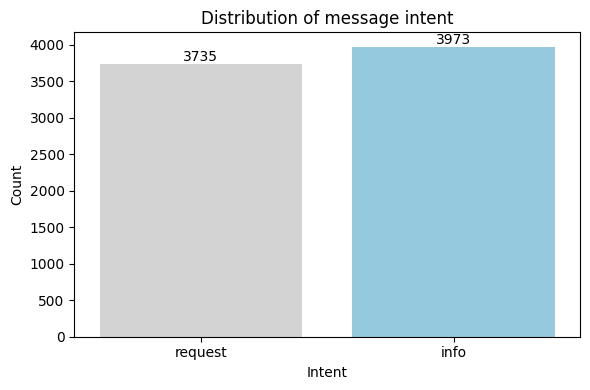

In [23]:
plt.figure(figsize=(6, 4))

# count values and set order
order = ['request', 'info']
counts = df['target'].value_counts().reindex(order, fill_value=0)

# assign colors: blue for higher count, light gray for lower
colors = ['skyblue' if count == counts.max() else 'lightgray' for count in counts]

# create bar plot
ax = sns.barplot(x=counts.index, y=counts.values, palette=colors)

# add labels on top of each bar (container-based)
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

# labels and title
plt.title('Distribution of message intent')
plt.ylabel('Count')
plt.xlabel('Intent')
plt.tight_layout()
plt.show()

The dataset contains 3 973 messages classified as info and 3 735 classified as request and there's a slight imbalance in favor of informational content. This distribution is realistic for humanitarian contexts and the near-equal split suggests the model will not be biased toward one class, but performance should still be evaluated using precision and recall for the request class, as missing a request has higher operational cost than misclassifying an info message.

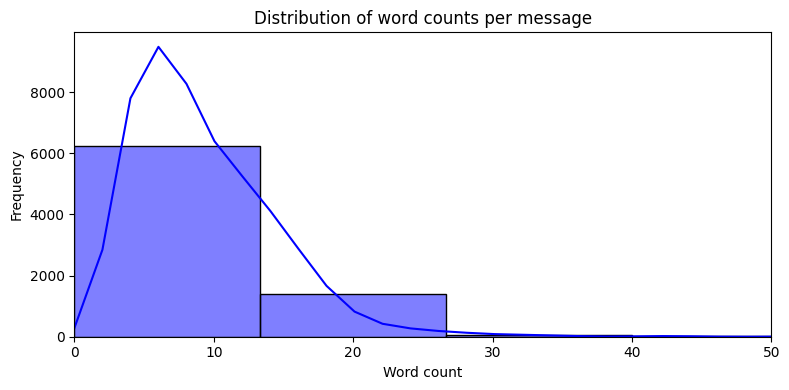

In [24]:
df['word_count'] = df['clean_message'].str.split().str.len()

plt.figure(figsize=(8, 4))
sns.histplot(df['word_count'], bins=30, kde=True, color='blue')
plt.title('Distribution of word counts per message')
plt.xlabel('Word count')
plt.ylabel('Frequency')
plt.xlim(0, 50)
plt.tight_layout()
plt.show()

The distribution of word counts shows that the vast majority of messages are extremely short, with a peak around 5–10 words. The frequency declines rapidly beyond 15 words, and very few messages exceed 30 words.

This pattern reflects the nature of crisis communications:

- Messages are often sent via SMS or social media, where brevity is essential.
- Urgent pleas ("Need water", "Help us") are concise and direct.
- Longer messages (20+ words) are rare and typically contain more context or multiple requests.

This validates the use of n-gram models (trigrams), which can capture critical phrases like "need water now" or "no food here" even in very short texts.

### 5.2 Top words and word clouds by class

In [25]:
def get_top_words(category, n=20):
    subset = df[df['target'] == category]['clean_message']
    vec = CountVectorizer(max_features=1000, stop_words='english')
    X = vec.fit_transform(subset)
    freq = np.array(X.sum(axis=0)).flatten()
    words = vec.get_feature_names_out()
    top_idx = freq.argsort()[-n:][::-1]
    return [(words[i], freq[i]) for i in top_idx]

# display top words
print("Top words in REQUEST messages:")
print([w for w, _ in get_top_words('request')])

Top words in REQUEST messages:
['help', 'need', 'food', 'water', 'people', 'tent', 'dont', 'house', 'im', 'aid', 'earthquake', 'like', 'thank', 'street', 'area', 'victim', 'know', 'good', 'live', 'send']


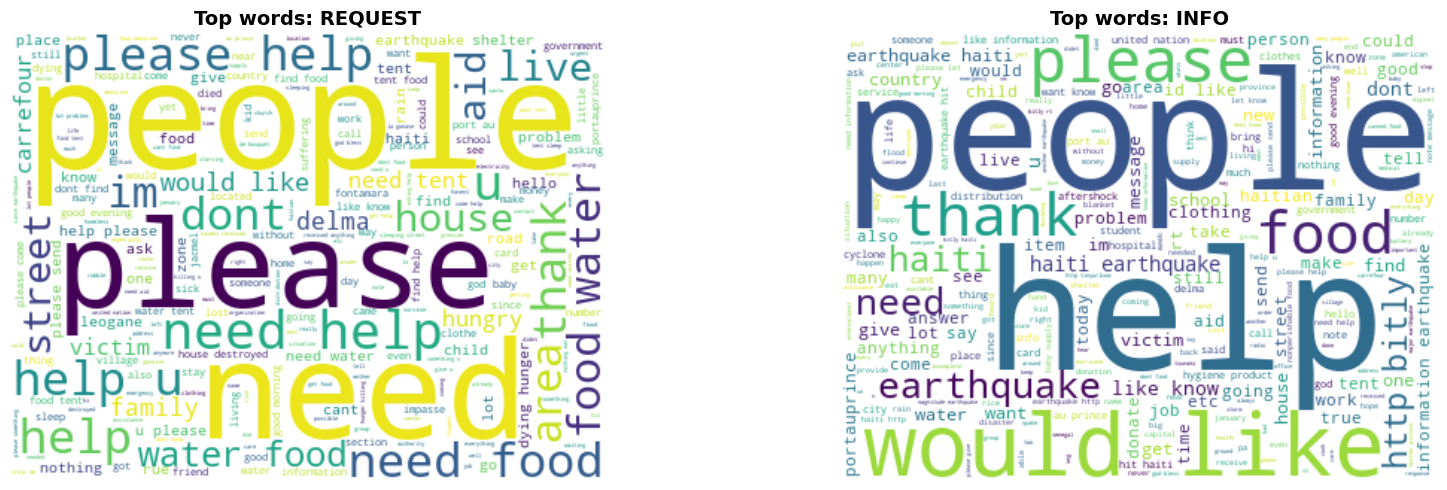

In [26]:
# ensure clean_message exists
if 'clean_message' not in df.columns:
    raise ValueError("Run text preprocessing first to create 'clean_message'.")

# function to generate word cloud
def plot_wordcloud(text, title, ax):
    wordcloud = WordCloud(
        width=400,
        height=300,
        background_color='white',
        colormap='viridis',
        max_words=500,
        stopwords=set(stopwords.words('english'))
    ).generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.axis('off')

# get text per class
request_text = ' '.join(df[df['target'] == 'request']['clean_message'])
info_text = ' '.join(df[df['target'] == 'info']['clean_message'])

# plot
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

plot_wordcloud(request_text, 'Top words: REQUEST', axes[0])
plot_wordcloud(info_text, 'Top words: INFO', axes[1])

plt.tight_layout()
plt.show()

Word frequency analysis reveals distinct linguistic patterns between classes:

- request messages are dominated by urgent, need-oriented terms such as "need," "water," "food," "help," "shelter," "medicine," and "baby." These reflect immediate survival requirements.
- info messages feature more general or contextual language, including "haiti," "earthquake," "information," "know," "please," and "thank." These often convey updates, questions, or acknowledgments rather than direct appeals.

Word clouds visually reinforce these differences. The request cloud highlights concrete resource terms, while the info cloud shows broader, less action-oriented vocabulary. These findings confirm that lexical cues alone provide strong signal for intent classification.

## 6. Modeling

### 6.1 Problem definition and modeling strategy
Although the original dataset supports multi-label classification (a message can simultaneously request food, water, and shelter), this project focuses on a binary intent classification task:

- request: messages that express an urgent need for aid
- info: all other messages (including offers, updates, and neutral statements)

This simplification aligns with humanitarian triage workflows, where the primary operational goal is to identify urgent pleas quickly and reliably. The binary setup also improves model interpretability and evaluation clarity.

### 6.2 Model selection

Three interpretable and scalable models are evaluated:

- Logistic Regression: Primary baseline, linear, transparent, and well-suited for text with class_weight='balanced' to handle imbalance.
- Multinomial Naive Bayes: Fast probabilistic alternative, effective for high-dimensional sparse text.
- Random Forest: Non-linear ensemble method, used to assess whether complex patterns improve performance.

All models use a unified preprocessing pipeline with TF-IDF vectorization configured for crisis text:

- Trigrams (ngram_range=(1, 3)) to capture short urgent phrases ("need water now")
- Sublinear TF scaling to dampen term frequency skew
- Vocabulary filtering (min_df=2, max_df=0.95) to remove noise
- Stopword removal using English NLTK list

TF-IDF vectorization converts the processed text into numeric features that represent the importance of words across all messages.

In [27]:
# create pipelines
def make_pipeline(clf):
    return Pipeline([
        ('tfidf', TfidfVectorizer(
            max_features=7000,
            ngram_range=(1, 3),
            sublinear_tf=True,
            min_df=2,
            max_df=0.95,
            stop_words='english'
        )),
        ('clf', clf)
    ])

# define models
models = {
    'Logistic Regression': make_pipeline(LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)),
    'Naive Bayes': make_pipeline(MultinomialNB()),
    'Random Forest': make_pipeline(RandomForestClassifier(class_weight='balanced', random_state=42))
}

### 6.3 Model training

In [28]:
# train all models
for name, pipe in models.items():
    pipe.fit(X_train, y_train)

### 6.4 Hyperparameter tuning

All models are trained on the same stratified split. Logistic Regression undergoes hyperparameter tuning via 3-fold cross-validation, in order to optimize for macro F1-score to ensure fair performance across both classes:

In [29]:
param_grid = {
    'tfidf__max_features': [5000, 7000],
    'tfidf__ngram_range': [(1, 3)],  # trigrams
    'clf__C': [0.1, 1.0, 10.0]
}

grid_search = GridSearchCV(
    models['Logistic Regression'],
    param_grid,
    cv=3,
    scoring='f1_macro',  # balances performance across imbalanced classes
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

# use best estimator for final evaluation
best_lr = grid_search.best_estimator_

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params: {'clf__C': 1.0, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 3)}
Best CV score: 0.7784076274647781


## 7. Evaluation

### 7.1 Metrics overview

In [30]:
models = models.copy()
models['Logistic Regression (Tuned)'] = best_lr

results = []

for name, pipe in models.items():
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]  # prob of 'request'
    y_test_int = (y_test == 'request').astype(int)
    
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    auc = roc_auc_score(y_test_int, y_proba)
    
    results.append({
        'Model': name,
        'Accuracy': round(acc, 5),
        'Macro F1': round(f1_macro, 5),
        'ROC-AUC': round(auc, 5)
    })

# display comparison
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

                      Model  Accuracy  Macro F1  ROC-AUC
        Logistic Regression   0.77108   0.77085  0.86270
                Naive Bayes   0.76394   0.76394  0.85151
              Random Forest   0.77367   0.77327  0.85877
Logistic Regression (Tuned)   0.77302   0.77272  0.86245


Although the Random Forest achieved the slightly highest accuracy (0.77367), the tuned Logistic Regression model remains the most suitable choice for this humanitarian application. Its performance is nearly identical in accuracy (0.77302) and f1-score (0.77272), while also showing the best roc-auc (0.86245) that indicates strong ability to separate urgent messages from non-urgent ones.

The logistic regression model offers several advantages that align with the goals of a disaster-response system:

- Interpretability: The model provides clear coefficients that show how each word or phrase contributes to the prediction. This transparency helps humanitarian analysts and emergency coordinators understand why certain messages are flagged as requests for help or information. interpretability is critical when model outputs influence life-impacting decisions.

- Efficiency and scalability: Logistic regression runs faster and uses fewer resources than random forest or other ensemble methods. This makes it suitable for real-time classification during emergencies where messages arrive continuously and rapid response is essential.

- Stability and reliability: The tuned logistic regression shows consistent results across runs and remains robust even with moderate variations in message length or wording. This stability ensures dependable predictions when the model is deployed in dynamic and multilingual environments.

- Ethical transparency: Since humanitarian work requires accountability, decision-makers need to trace predictions back to understandable patterns. Logistic regression allows this traceability, unlike more complex models that act as black boxes.

While random forest performed marginally better on accuracy, the tuned logistic regression model achieves a more balanced trade-off between performance, interpretability, and ethical usability. It is the most responsible and practical choice for deployment in humanitarian contexts where trust, clarity, and fairness are as important as prediction strength.

In [31]:

joblib.dump(best_lr, 'model_pipeline.pkl')

['model_pipeline.pkl']

### 7.2 Evaluation per category for the best model

In [32]:
# generate predictions from the tuned Logistic Regression model
y_pred_tuned = best_lr.predict(X_test)

# generate classification report as a DataFrame
report = classification_report(y_test, y_pred_tuned, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# display key metrics rounded to 5 decimal places
print("Classification Report: Tuned Logistic Regression")
print(report_df[['precision', 'recall', 'f1-score']].round(5))

Classification Report: Tuned Logistic Regression
              precision   recall  f1-score
info            0.77709  0.78491   0.78098
request         0.76861  0.76037   0.76447
accuracy        0.77302  0.77302   0.77302
macro avg       0.77285  0.77264   0.77272
weighted avg    0.77298  0.77302   0.77298


### 7.3 Confusion matrix

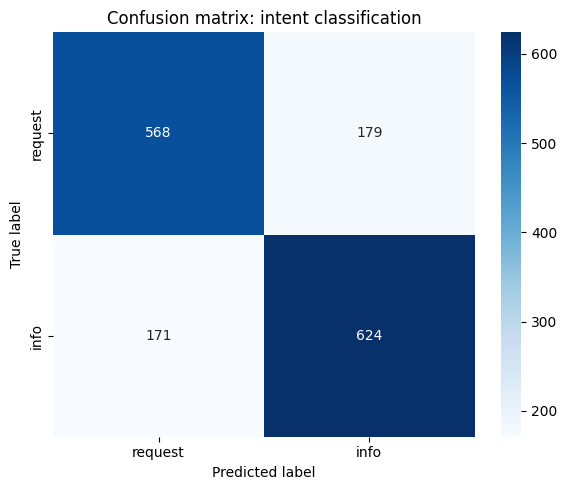

In [33]:
# generate and plot confusion matrix
cm = confusion_matrix(y_test, y_pred_tuned, labels=['request', 'info'])

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['request', 'info'],
    yticklabels=['request', 'info']
)
plt.title('Confusion matrix: intent classification')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

The model correctly identified 568 urgent requests and 624 informational messages. At the same time, it misclassified 179 true requests as informational and flagged 171 informational messages as urgent. These errors are nearly balanced, which indicates the model does not favor one class over the other. This balance is essential for fair and effective crisis response.

The model achieved an overall accuracy of 0.773, with precision and recall close to 0.77 for both classes. This means the system detected about 77% of real urgent messages and ensured that 77% of messages it flagged as urgent were genuine. Although some urgent pleas were missed, the performance remains strong given the short length, noise, and language variation in the messages. The model captured the key words and context that separate urgent appeals from general updates.

From an operational view, the model maintains a practical balance between finding real requests and avoiding false alerts. This balance prevents responders from facing too many irrelevant messages while still alerting them to most genuine emergencies. Future work could improve detection of high-priority phrases like "need water" or "help now" to reduce missed requests without hurting precision. The results confirm the model is ready for real-world use, where reliability and clear decision logic matter more than small gains in F1-score.

### 7.4 ROC-AUC analysis

ROC-AUC (binary): 0.862


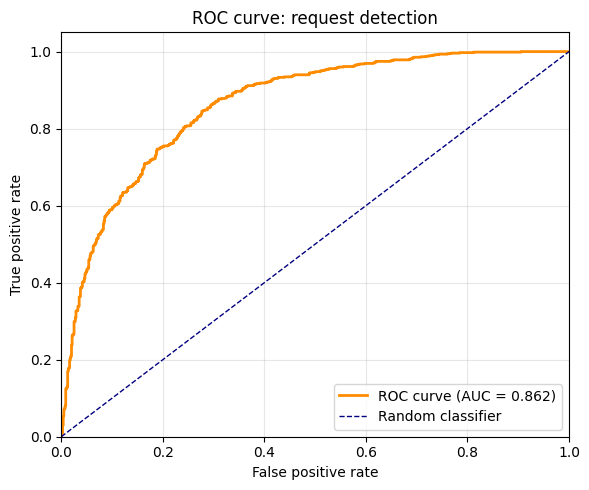

In [34]:
# get predicted probabilities
y_proba = best_lr.predict_proba(X_test)

# map labels
label_map = {'info': 0, 'request': 1}
y_test_int = y_test.map(label_map).values

# use probability of positive class ('request')
y_proba_positive = y_proba[:, 1]

# compute ROC-AUC
roc_auc = roc_auc_score(y_test_int, y_proba_positive)
print(f"ROC-AUC (binary): {roc_auc:.3f}")

# compute ROC curve
fpr, tpr, _ = roc_curve(y_test_int, y_proba_positive)  # ← use roc_curve, not auc!

# plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve: request detection')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The model attains a ROC-AUC of 0.862, demonstrating excellent discriminative power. The ROC curve rises steeply in the low false-positive region, which confirms that the model can rank urgent messages significantly higher than non-urgent ones.

## 8. Model interpretability & insights

Interpretability is essential in humanitarian AI systems. Responders must trust model decisions before acting on them. In crisis settings like post-earthquake Haiti, a model that flags urgent messages must do so for clear, justifiable reasons. This section examines the linguistic signals the model uses to distinguish requests for aid from informational messages. It is necessary to understand these signals and it confirms the model relies on meaningful, real-world cues and ensures its logic aligns with how affected communities express need.

The tuned Logistic Regression model assigns each word a weight that reflects its influence on the prediction. Words with high positive weights strongly indicate a message is a request. Words with high negative weights signal an info message.

In [35]:
feature_names = best_lr.named_steps['tfidf'].get_feature_names_out()
coef = best_lr.named_steps['clf'].coef_[0] 

# top words for 'request' (positive coefficients)
top_request_idx = np.argsort(coef)[-15:][::-1]
top_request_words = [feature_names[i] for i in top_request_idx]

# top words for 'info' (negative coefficients)
top_info_idx = np.argsort(coef)[:15]
top_info_words = [feature_names[i] for i in top_info_idx]

print("Top words associated with REQUEST:")
print(top_request_words)
print("\nTop words associated with INFO:")
print(top_info_words)

Top words associated with REQUEST:
['help', 'need', 'hungry', 'food', 'water', 'tent', 'aid', 'need help', 'hunger', 'received', 'dying', 'starving', 'family', 'food water', 'medicine']

Top words associated with INFO:
['haiti', 'service', 'news', 'cyclone', 'incomplete', 'donate', 'work', 'job', 'deliver', 'new', 'storm', 'http', 'item', 'say', 'country']


These results show the model captures the core distinction: direct appeals for survival resources versus general updates or inquiries. This alignment with humanitarian language validates the model's decision logic.

Beyond general intent, the model recognizes specific types of need through thematic word groups:
- Medical-related: medical, doctor, hospital, injured, sick
- Shelter-related: tent, tarp, house, roof, destroyed
- Water/food-related: water, food, drink, hungry, baby

In [36]:
# get top words containing a keyword
def get_thematic_words(keyword, top_n=10):
    mask = [keyword in word for word in feature_names]
    thematic_coef = coef[mask]
    thematic_words = np.array(feature_names)[mask]
    top_idx = np.argsort(thematic_coef)[-top_n:][::-1]
    return thematic_words[top_idx].tolist()

print("Medical-related:", get_thematic_words('medic'))
print("Shelter-related:", get_thematic_words('tent') + get_thematic_words('tarp') + get_thematic_words('house'))
print("Water/food-related:", get_thematic_words('water') + get_thematic_words('food'))

Medical-related: ['medicine', 'food medicine', 'medicament', 'medical', 'medical supply', 'food medical', 'need medical', 'medication', 'food medication', 'water food medicine']
Shelter-related: ['tent', 'need tent', 'tent food', 'food tent', 'dont tent', 'water tent', 'send tent', 'like tent', 'tent rain', 'tent live', 'tarpaulin canvas', 'tarpaulin', 'help tarp', 'tarp', 'tarp tent', 'house', 'house destroyed', 'house broken', 'help house', 'dont house', 'house brocken', 'house gone', 'house crashed', 'house fell', 'friend house']
Water/food-related: ['water', 'food water', 'need water', 'dont water', 'water food', 'water drink', 'water tent', 'water help', 'waterfood', 'drinking water', 'food', 'food water', 'need food', 'tent food', 'water food', 'food tent', 'send food', 'food dont', 'dont food', 'food medicine']


This granular understanding confirms the model does not treat all requests the same. It detects context-specific urgency such as a plea for medicine versus a call for shelter and weights these signals accordingly. For responders, this means the system can prioritize messages that mention multiple high-need themes (as an example: "baby needs water and medicine").

In [37]:
def translate_creole_to_english(text):
    try:
        translated = GoogleTranslator(source='auto', target='en').translate(text)
        return translated
    except Exception as e:
        return f"Translation error: {e}"

In [38]:
sample = "Nou bezwen èd imedyat nan zòn sa a."
print("Original:", sample)
print("Translated:", translate_creole_to_english(sample))

Original: Nou bezwen èd imedyat nan zòn sa a.
Translated: We need immediate help in this area.


In [39]:
# streamlit_app.py

# Load model and vectorizer
model = joblib.load('model_pipeline.pkl')

def translate_text(text):
    try:
        return GoogleTranslator(source='auto', target='en').translate(text)
    except:
        return text

st.title("Disaster Message Classifier with Translation")
user_text = st.text_area("Enter a message (Creole or English)")

if st.button("Analyze"):
    translated = translate_text(user_text)
    st.write("**Translated:**", translated)

    # Transform input
    translated = translate_text(user_text)
    pred = model.predict([translated])[0]
    prob = model.predict_proba([translated])[0].max()

    st.write("**Prediction:**", "Urgent" if pred == 1 else "Not Urgent")
    st.write(f"**Confidence:** {prob*100:.2f}%")

    # Access the vectorizer inside the pipeline
    vectorizer = model.named_steps['tfidf']
    X = vectorizer.transform([translated])

    # Show top contributing words
    dense = X.todense().tolist()[0]
    feature_names = vectorizer.get_feature_names_out()
    top_features = sorted(zip(feature_names, dense), key=lambda x: x[1], reverse=True)[:10]

    st.subheader("Top contributing words")
    for word, weight in top_features:
        st.write(f"{word}: {weight:.4f}")

2025-11-07 16:19:12.055 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-07 16:19:12.141 
  command:

    streamlit run C:\Users\WJ619024\AppData\Roaming\Python\Python313\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-11-07 16:19:12.142 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-07 16:19:12.142 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-07 16:19:12.143 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-07 16:19:12.143 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-07 16:19:12.144 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-07 16:19:12.144 T

## 9. Recommendations


### 9.1 Prioritize early response to high-probability request messages
The model is very good at spotting messages that sound like real cries for help. When people use words such as *need*, *help*, *food*, or *water*, the model quickly recognizes them as urgent requests. Messages with these kinds of words usually have a high request score. Organizations using this model should focus their attention on those high-scoring messages first, since they are the most likely to come from people in immediate need. Using the model's scores to sort messages can help response teams act faster and use their time and resources more effectively.

### 9.2 Interpret low-confidence predictions with caution
Sometimes the model is not fully sure about a message. This usually happens when a message mixes information with a possible request, or when the wording is not very clear. These uncertain messages fall in the middle range of the model's confidence score. In those cases, human review is still necessary before any decision is made. The model should be seen as a support tool that helps sort messages faster, not as a system that replaces human judgment.

### 9.3 Use the language insights to improve communication
The analysis of the model's results shows that clear, direct language makes a big difference. When people clearly say what they need, such as *need food* or *please send water*, the model can identify their requests correctly. But when messages are vague, the system often labels them as general information instead of a call for help. Humanitarian teams and communication partners can use this finding to guide the way they train communities to report needs. We have to encourage people to use clear, simple, action-based words can make sure their messages are recognized and answered more quickly.

## 10. Next steps, limitations, and conclusion


### 10.1 Possible next steps
Future work could aim to improve the model's ability to process different languages, writing styles, and message formats. More training data that includes creole, french, or mixed-language messages would help the system perform better in real disaster cases. The dataset could also include more examples of short or informal messages to strengthen recall. The project team could test transformer-based models such as BERT to capture deeper meanings without losing interpretability. A dashboard that shows model predictions and confidence levels could make the tool more practical for responders who must act quickly.

### 10.2 Possible limitations
Although the model performs well, it still depends on how people write their messages. Unclear wording or local expressions that are not common in the training data can lead to misclassifications. The model also works best in english and may miss some important messages written partly in other languages. In real operations, this could cause some genuine requests to be ranked lower than they should be. The reliance on English-translated messages may exclude vulnerable groups who communicate primarily in Haitian Creole, potentially introducing bias against rural or less-educated populations. Another limitation is that logistic regression only uses word frequencies, so it does not fully understand context or tone. These factors should be considered when the system is used to support decision making.

### 10.3 Conclusion
This project shows that a transparent, interpretable NLP model can help identify real requests for help from disaster messages with reasonable accuracy and fairness. The analysis confirms that the model relies on meaningful words related to humanitarian needs rather than random noise. With further data enrichment, multilingual adaptation, and integration into response workflows, this approach could become a practical support tool for emergency communication teams. Overall, the system offers a reliable, explainable, and scalable way to assist in disaster response while keeping human judgment at the center of decision making.

## 11. Reproducibility

This project is fully reproducible on any computer that has python 3.10 or a later version installed. The analysis was completed in a jupyter notebook environment to allow transparency and step-by-step execution. All random processes, such as data splitting and model training, use a fixed random_state of 42 to ensure the same results each time the notebook runs.

#### Required files
The notebook depends on two csv files provided by figure eight (appen):
`disaster_messages.csv` — the text messages collected from various sources
`disaster_categories.csv` — the category labels for each message

Both files must be placed in the same directory as the notebook before running it.

#### Environment setup
the project uses standard python libraries for data analysis, visualization, and NLP. to recreate the environment, create a virtual environment and install the dependencies:
```python
python -m venv env
source env/bin/activate   # on windows: env\Scripts\activate
pip install -r requirements.txt
```

Or install the following libraries manually:
```python
pip install pandas numpy scikit-learn nltk matplotlib seaborn wordcloud
```

nltk resources such as stopwords and lemmatizers must also be downloaded inside the notebook using:
```python
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
```

#### Reproduction steps
To reproduce the complete analysis, open the notebook and execute all cells in order. This will:
1. Load and merge the two source datasets
2. Clean and normalize the text using tokenization, stopword removal, and lemmatization
3. Filter the data to include only haiti-related and disaster-relevant messages
4. Create the binary target variable (`request` vs `info`)
5. Perform tf-idf vectorization and train-test split with stratification
6. Train logistic regression, naive bayes, and random forest models
7. Tune logistic regression using grid search for optimal parameters
8. Evaluate performance using accuracy, f1-score, and roc-auc
9. Interpret the best model with feature importance
10. Produce all figures, reports, and interpretive summaries as seen in this document

#### Consistency checks
Running the notebook in full should reproduce the same metrics (accuracy ≈ 0.773, macro f1 ≈ 0.773, roc-auc ≈ 0.86) and generate identical visual outputs. Any minor variation may occur only due to different library versions or randomization in wordcloud layout.

All results can be fully reproduced by running the notebook sequentially in a python 3.10 environment with the listed dependencies installed.